In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def f(x):
    return 3*x**2 - 4*x + 5

In [13]:
f(3.0)

20.0

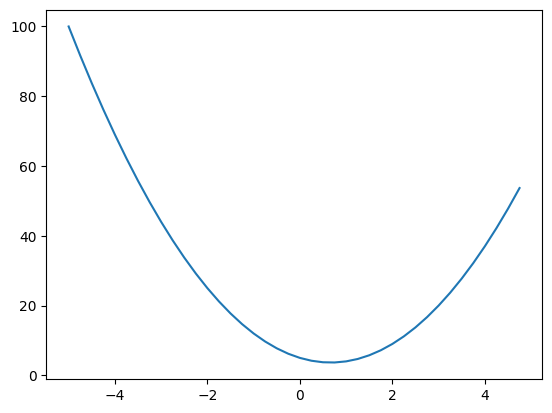

In [15]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [8]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})# LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label ="{ %s | data %.4f | grad %.4f }"%(n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid +n._op, label =n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect nl to the op node of n2
        dot.edge(str(id(n1)),str(id(n2))+ n2._op)
    return dot 

In [162]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only support int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += out.grad * other * self.data **(other-1)
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):   # self / other
        return self * other ** -1

    def __neg__(self): #-self
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
        

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad = out.data * out.grad  ##是否需要加好？
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [163]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.88137387, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e-1) / (e+1); o.label = 'o'

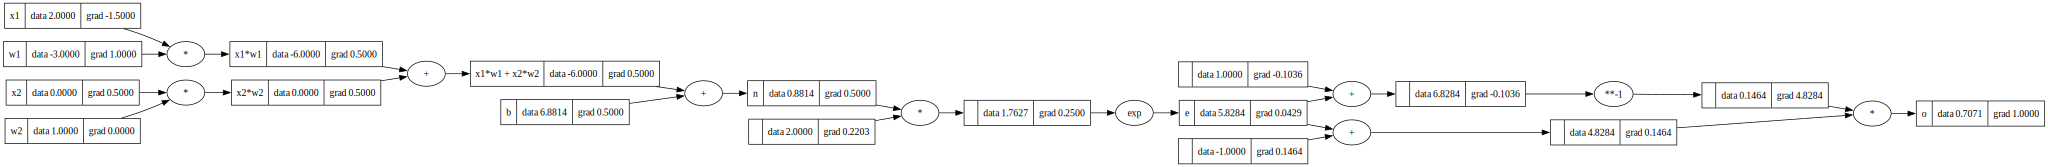

In [164]:
o.backward()
draw_dot(o)

In [165]:
import torch
import random

In [166]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137387]).double();b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071069288235958
---
x2 0.4999997912096622
w2 0.0
x1 -1.4999993736289867
w1 0.9999995824193244


In [372]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        # print( (zip(self.w, x)))
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
        


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] 
        

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7180464511648449)

In [373]:
n.parameters()

[Value(data=-0.5437966455461765),
 Value(data=-0.23156208209548645),
 Value(data=0.6921879100656778),
 Value(data=0.7160562057111599),
 Value(data=-0.2511003609673885),
 Value(data=-0.06761570174794107),
 Value(data=-0.7268650014341782),
 Value(data=-0.39050466632389624),
 Value(data=0.7714783384416277),
 Value(data=-0.45450755394341025),
 Value(data=-0.8756369749409127),
 Value(data=0.5090039450694732),
 Value(data=-0.007597315684914285),
 Value(data=0.9443732849110911),
 Value(data=-0.3723956704713185),
 Value(data=-0.7074169471238865),
 Value(data=-0.2573754490652176),
 Value(data=-0.03195999421346207),
 Value(data=-0.19058256889451175),
 Value(data=0.5609086113074488),
 Value(data=-0.4858897098684578),
 Value(data=-0.6192954288696251),
 Value(data=0.47435570581985154),
 Value(data=-0.3696862304760047),
 Value(data=0.40306148219476357),
 Value(data=0.7308600785129067),
 Value(data=-0.48519888878564865),
 Value(data=0.5731966087032356),
 Value(data=-0.22868998495871673),
 Value(data=

In [374]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [381]:
for k in range(50):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0 
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)
    

0 0.004699836135908532
1 0.004614272205760244
2 0.0045316828833834605
3 0.0044519175116106875
4 0.004374835372107195
5 0.004300304882482734
6 0.004228202869775006
7 0.004158413911979853
8 0.004090829740321921
9 0.004025348695841719
10 0.003961875234638561
11 0.003900319476771782
12 0.0038405967944003276
13 0.003782627435243901
14 0.0037263361778887344
15 0.003671652015845917
16 0.003618507867608642
17 0.0035668403102510383
18 0.0035165893343730562
19 0.0034676981184263394
20 0.0034201128206598434
21 0.003373782387103956
22 0.0033286583741721372
23 0.003284694784600784
24 0.0032418479155740167
25 0.0032000762179928257
26 0.003159340165947893
27 0.0031196021355451137
28 0.0030808262923127903
29 0.0030429784864911824
30 0.003006026155569233
31 0.002969938233491467
32 0.002934685066009076
33 0.00290023833169708
34 0.0028665709682004687
35 0.0028336571033106966
36 0.002801471990508439
37 0.00276999194863904
38 0.002739194305415425
39 0.002709057344468804
40 0.00267956025569043
41 0.00265068

In [382]:
ypred

[Value(data=0.9820237401711501),
 Value(data=-0.9806918559265274),
 Value(data=-0.9708136819861776),
 Value(data=0.9701328156440999)]

In [361]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.52914909809971e-08)

In [362]:
loss.backward()

In [363]:
n.layers[0].neurons[0].w[0].grad

-7.370173544125722

In [364]:
n.layers[0].neurons[0].w[0].data

1.7090589235337972

In [365]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [366]:
ypred

[Value(data=0.9998909064406118),
 Value(data=-0.9999710050353839),
 Value(data=-0.9999946124867124),
 Value(data=0.9998881056167249)]